### Get Data

- Step 1: Make a path to directory storing Data
- Step 2: Crawl Data from website
- Step 3: Extract zip file
- Step 4: Read it in csv form

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [3]:
def load_housing_data():
    tarball_path = Path("data/housing.tgz")
    if not tarball_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="data")
    return pd.read_csv(Path("data/housing/housing.csv"))

housing = load_housing_data()

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> Note:
- dtype of ocean_proximity is objects
- total_bedrooms missed data

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


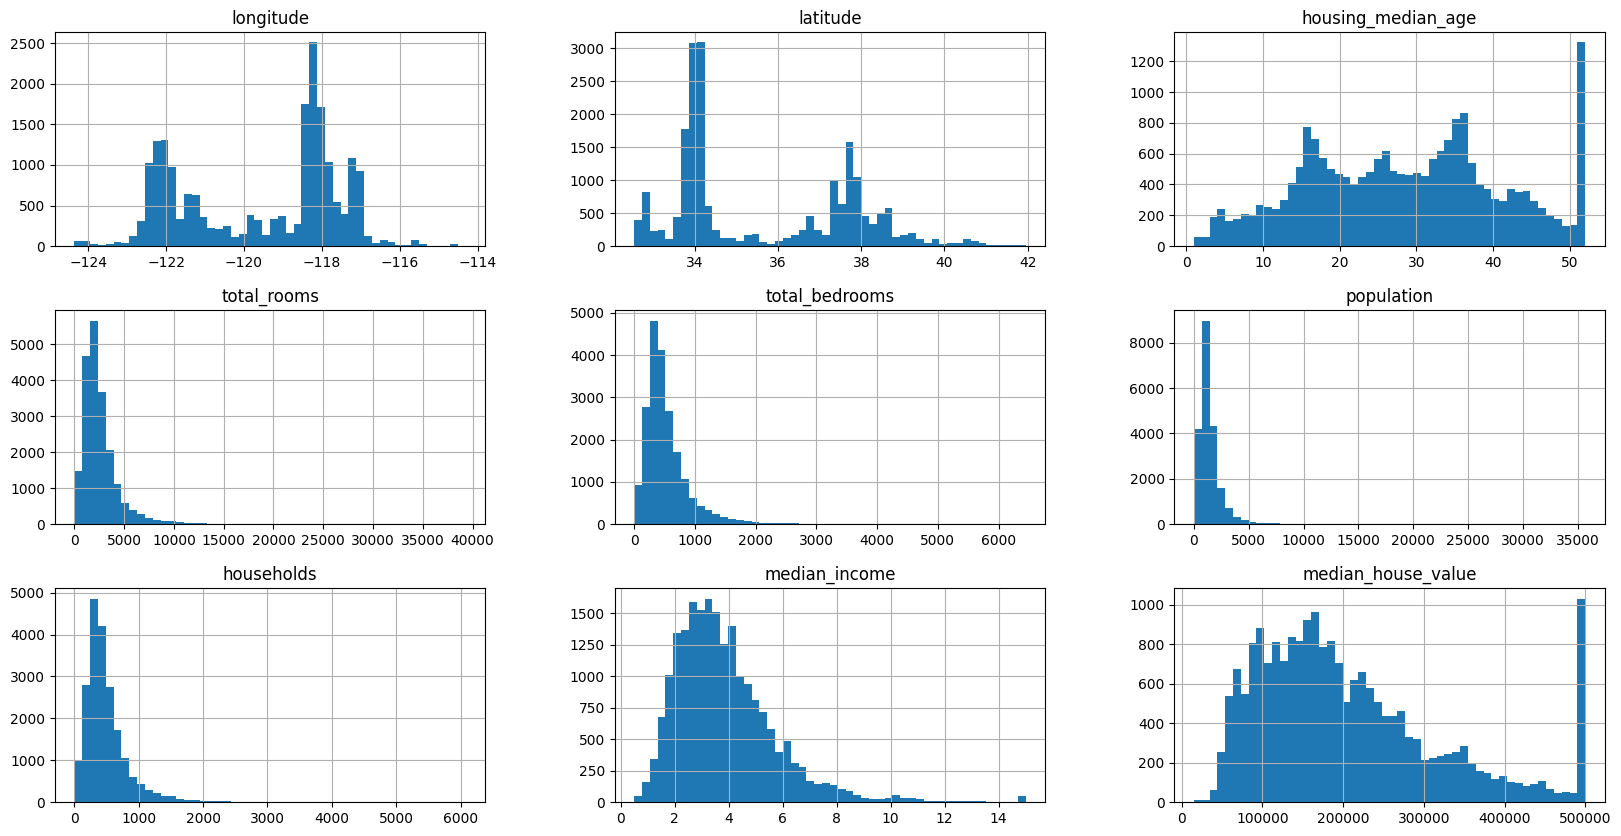

In [9]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,10))
plt.show()

> Note:
- the median income attribute does not express in USD.

Now, we make an split data function to prepare test set.

In [10]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    # generate random index (indices) in data
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    # seperate the length of test and train set
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]
    # return specific train and test set with "iloc" function
    return data.iloc[train_indices], data.iloc[test_indices]
    

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print(len(train_set),len(test_set))

16512 4128


> Notice:
- This method is not stable when generating test, train.
- In next time, it will give a different set which shoud be avoid

So now are some methods you can use:

In [12]:
"""
you could compute a hash of each instance’s
identifier and put that instance in the test set if the hash is lower than or equal
to 20% of the maximum hash value.
"""
from zlib import crc32

def is_id_test(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: is_id_test(id, test_ratio))
    return data[~in_test_set], data[in_test_set]

# Unfortunately, the dataset does not have identifier column, thus, we have to make

housing_with_id = housing.reset_index() # add an "index" column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

# You must make sure that the id won't be lost if we update, modify
# Another solution is build "id" from another attributes such as: longtitute, latitute

housing_with_id["id"] = housing["longitude"]*1000 + housing["latitude"]

In [13]:
# Otherwise, you can use Sikit-learn function: train_test_split()
# It seperate with random indices and have parameter random_state which make it stably

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### There is another strategy to split the dataset
> This is called stratified sampling: the
> population is divided into homogeneous subgroups called strata, and the right
> number of instances are sampled from each stratum to guarantee that the test
> set is representative of the overall population

In [14]:
# from sklearn.model_selection import StratifiedShuffleSplit

# splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# strat_splits = []
# for train_index, test_index in splitter.split(housing, housing["income_cat"]):
#     strat_train_set_n = housing.iloc[train_index]
#     strat_test_set_n = housing.iloc[test_index]
#     strat_splits.append([strat_train_set_n, strat_test_set_n])

## Explore and Visualize the Data

we have only a quick glance at the data, so now we go deeper to get the insight, just only in train_set. Because the train data is not large, so we work with full set instead of split it out. In order to remain the original train set, we will make a copy. 

In [15]:
housing = train_set.copy()
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16349 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


### Visualizing Geopraphical Data
Because the dataset includes geographical data, it is recommended to visualize it first.

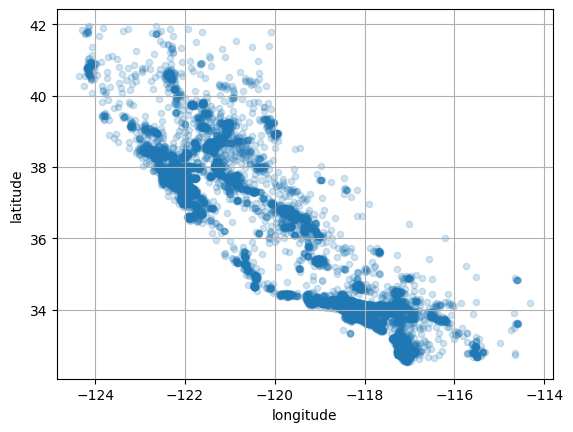

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
# alpha is the level of density of the scatter
plt.show()

> Now we can use more attributes to visualize:
- Population is the circle (option s)
- Price is represented by color (option c), cmap = "jet" means ranges from blue to red

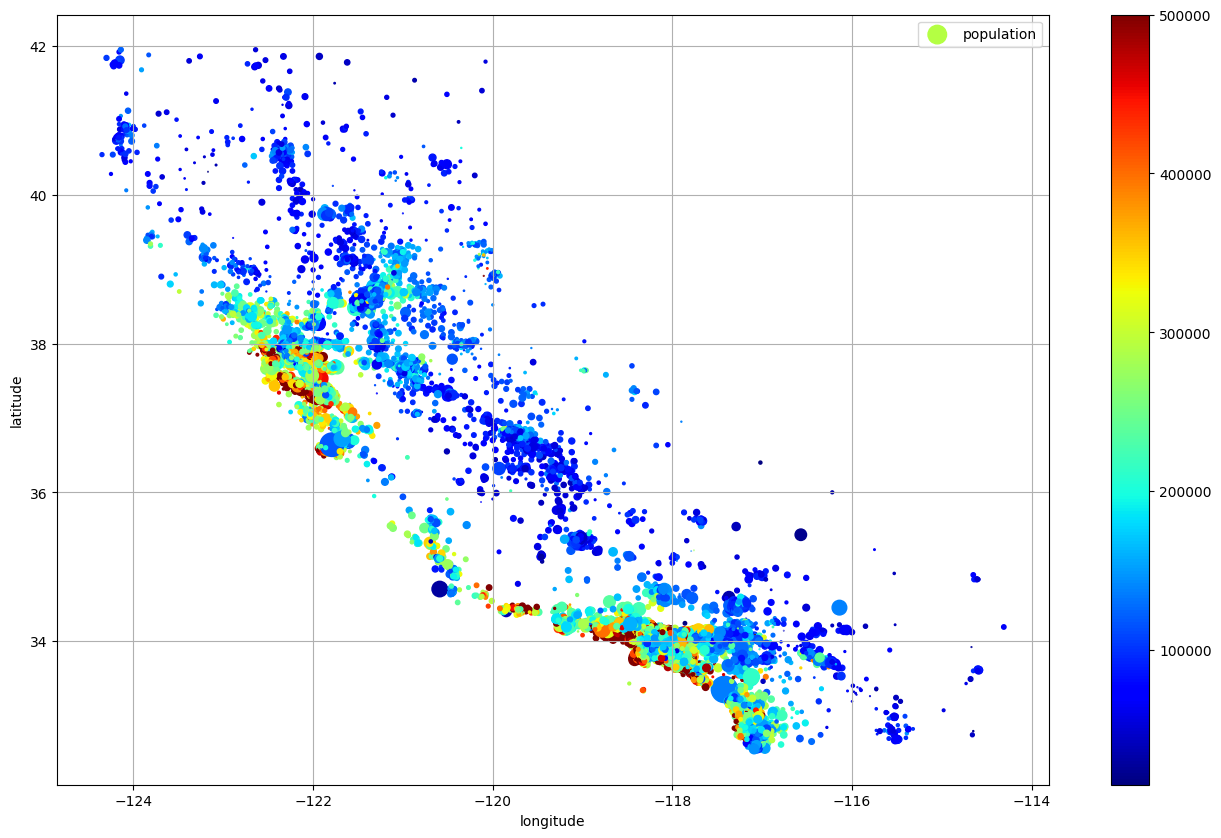

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
            s = housing["population"]/100, label="population",
            c = housing["median_house_value"], cmap="jet", colorbar=True,
            legend=True,  figsize=(16,10))
plt.show()

### Look for Correlations
Since the dataset is not too large, you can easily compute the standard
correlation coefficient between every pair of
attributes using the corr() method:

In [18]:
corr_matrix = housing.corr()
# Because our target is median house value so we look at its correlations.
corr_matrix["median_house_value"].sort_values(ascending=False)

C:\Users\T590\AppData\Local\Temp\ipykernel_9120\3251598836.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

The correlation ranges from –1 to 1. When it is close to 1, it
means that there is a strong positive correlation; for example, the median
house value tends to go up when the median income goes up. When the
coefficient is close to –1, it means that there is a strong negative correlation;

In [19]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878,291000.0,NEAR OCEAN
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648,156100.0,NEAR OCEAN
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875,353900.0,NEAR BAY
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663,241200.0,<1H OCEAN
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688,53800.0,INLAND


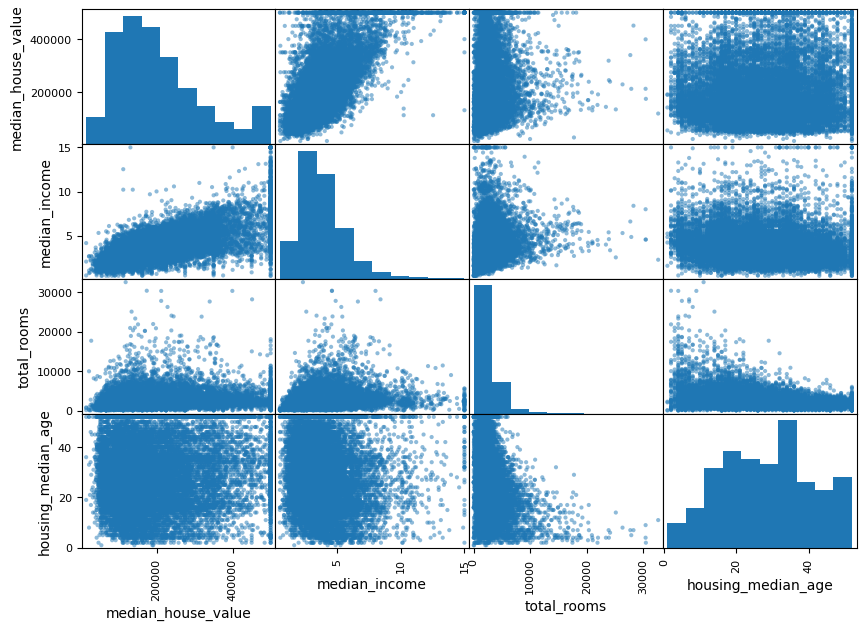

In [20]:
import pandas as pd
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(10,7))
plt.show()

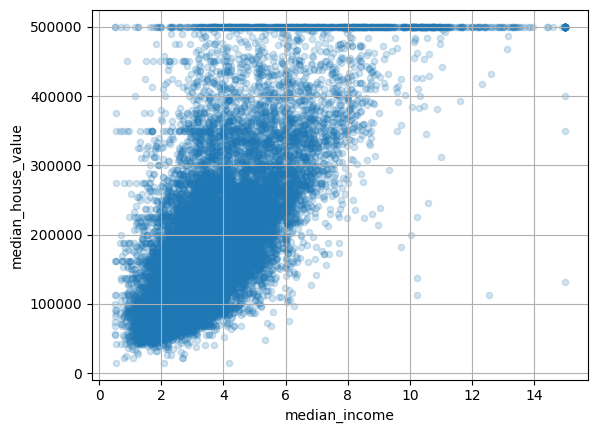

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", grid=True, alpha=0.2)
plt.show()

This plot reveals a few things:
- the correlation is indeed quite strong
- A horizonal line at 500,000, and perhaps at 450k and 350k. It will be dangerous for our algorithms. So we should clear it before trainning our model.

### Experiments with Attribute Combinations
One last thing you may want to do before preparing the data for machine
learning algorithms is to try out various attribute combinations. Combine somethings together and see the results.

In [22]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16349 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [23]:
# We try making more attributes from orginal attributes 
housing["ratio_bedrooms"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing.population / housing.households
housing["rooms_per_house"] = housing.total_rooms / housing.households
housing["position"] = housing.longitude + housing.latitude

In [24]:
# Now let see the results
matrix_corr = housing.corr()
matrix_corr["median_house_value"].sort_values(ascending=False)

C:\Users\T590\AppData\Local\Temp\ipykernel_9120\4053545501.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix_corr = housing.corr()


median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
people_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
ratio_bedrooms       -0.254817
position             -0.490287
Name: median_house_value, dtype: float64

## Prepare the Data for Algorithms
> Instead of preparing data manually, we should write functions because:
- This will allow you to reproduce these transformations easily on any
dataset (e.g., the next time you get a fresh dataset).
- You will gradually build a library of transformation functions that you
can reuse in future projects.
- You can use these functions in your live system to transform the new
data before feeding it to your algorithms.
- This will make it possible for you to easily try various transformations
and see which combination of transformations works best.


In [25]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

> Clean the Data
Most machine learning algorithms cannot work with missing features, so
you’ll need to take care of these. Some common solutons:
1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median, etc.).
This is called imputation.


In [26]:
# housing.dropna(subset=["total_bedrooms"], inplace=True) # option 1
# housing.drop("total_bedrooms", axis=1) # option 2
# median = housing["total_bedrooms"].median() # option 3
# housing["total_bedrooms"].fillna(median, inplace=True)

In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, you then
need to create a copy of the data with only the numerical attributes (this will
exclude the text attribute ocean_proximity)

In [28]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [29]:
X = imputer.transform(housing_num)

In [30]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Handling Text and Categorical Attributes
So far we have only dealt with numerical attributes, but your data may also
contain text attributes. In this case, it's ocean_proximity


In [31]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
14196,NEAR OCEAN
8267,NEAR OCEAN
17445,NEAR BAY
14265,<1H OCEAN
2271,INLAND


For this, we can use Scikit-Learn’s
OrdinalEncoder class

In [32]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [33]:
housing_cat_encoded[:5]

array([[4.],
       [4.],
       [3.],
       [0.],
       [1.]])

There are some way to encode the categories, now we try with one-hot encoding.This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others
will be 0 (cold). The new attributes are sometimes called dummy attributes.
Scikit-Learn provides a OneHotEncoder class to convert categorical values
into one-hot vectors

In [34]:
from sklearn.preprocessing import OneHotEncoder
hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
housing_cat_1hot = hot_encoder.fit_transform(housing_cat)

In [35]:
housing_cat_1hot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Feature Scaling and Transformation
One of the most important transformations you need to apply to your data is
feature scaling. There are two common ways to get all attributes to have the same scale: min-max scaling and standardization.

In [36]:
# Min-max scaling
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [37]:
# Standardization: subtracts the mean value -> divides the result by the standard deviation
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)


### Pipelines
There are many data transformation steps that need to be
executed in the right order. Fortunately, Scikit-Learn provides the Pipeline
class to help with such sequences of transformations

In [38]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="median")),
    ('standardize', StandardScaler())    
])

In [39]:
from sklearn.pipeline import make_pipeline

In [40]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [41]:
# if you want to recover a nice DataFrame, you can use the 
# pipeline’s get_feature_names_out() method:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
                                       index=housing_num.index)

> So far, we have handled the categorical columns and the numerical columns
> separately. It would be more convenient to have a single transformer capable
> of handling all columns, applying the appropriate transformations to each
> column. For this, you can use a ColumnTransformer.

In [42]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
"total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy="most_frequent")),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [43]:
# If you found that listing all attibutes is not convenient,
# you can use make_column_selector,
# and also make_column_transformer if you don't care about name of components of pipeline
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [44]:
housing_prepared = preprocessing.fit_transform(housing)

## Select and Train a Model
At last! You framed the problem, you got the data and explored it, you
sampled a training set and a test set, and you wrote a preprocessing pipeline
to automatically clean up and prepare your data for machine learning
algorithms. You are now ready to select and train a machine learning model.

Thanks to all these previous steps, things are now going
to be easy! You decide to train a very basic linear regression model to get
started

In [45]:
from sklearn.linear_model import LinearRegression

line_regress = make_pipeline(preprocessing, LinearRegression())
line_regress.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B11DD510>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B1199570>)])),
                ('linearregression', LinearRegression())])

In [46]:
housing_prediction = line_regress.predict(housing)
print(pd.DataFrame(housing_prediction[:10],columns=["price"]))
print(housing_labels[:10])

           price
0  288032.981031
1  227257.002946
2  291933.856196
3  265790.857639
4   21816.542798
5  515755.647435
6   68875.450385
7  203183.380170
8   60636.903890
9  219831.264571
14196    291000.0
8267     156100.0
17445    353900.0
14265    241200.0
2271      53800.0
17848    500001.0
6252      54400.0
9389     145800.0
6113     173400.0
6061     172600.0
Name: median_house_value, dtype: float64


It works, but not so good. We choose to use the RMSE (Root Mean Squared Error) to measure our performance.

In [49]:
from sklearn.metrics import mean_squared_error
lin_rmse = mean_squared_error(housing_labels, housing_prediction, squared=False)
lin_rmse

68458.01274733282

This is better than nothing, but clearly not a great score. So I try another model: DecisionTreeRegression

In [50]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B11DD510>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B1199570>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Now, the model is trained, we evaluate it on the training set

In [51]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_predictions, housing_labels, squared=False)
tree_rmse

0.0

Unbelievable! No error at all? No, it means that your model is badly overfitting the data.

### Better evaluation using cross-validation

One way to evaluate the decision tree model would be to use the train_
test_split() function to split the training set into a smaller training set and a
validation set, then train your models against the smaller training set and
evaluate them against the validation set. It’s a bit of effort, but nothing too
difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn’s k_-fold cross-validation feature.

In [54]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)

Take a look at the results:

In [55]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     68363.399430
std       1404.275065
min      66637.815189
25%      67580.025452
50%      67866.551569
75%      68641.010461
max      71025.060246
dtype: float64

It seems to perform almost as poorly as the linear regression model! The decision tree has an RMSE of about 66,363, with a standard deviation of about 1,404. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always convinient. Now let's try with the last one: The RandomForestRegressor. . Such models composed of many other models are called ensembles: they are capable of boosting the performance of the underlying model (in this case, decision trees). 

In [56]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmse).describe()

count       10.000000
mean     48779.255273
std       1003.837260
min      47054.221523
25%      48101.394627
50%      48655.890987
75%      49678.071994
max      50215.543791
dtype: float64

## Fine-Tune your model

### Grid Search
Instead, you can use Scikit-Learn’s GridSearchCV class to search for you.
All you need to do is tell it which hyperparameters you want it to experiment
with and what values to try out, and it will use cross-validation to evaluate all
the possible combinations of hyperparameter values.

In [58]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
("preprocessing", preprocessing),
("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
{'random_forest__max_features': [4, 6, 8]},
{'random_forest__max_features': [6, 8, 10]},]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardize',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B11DD510>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy...
                                                                                         ('encode',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B1199570>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [4, 6, 8]},
                         {'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

### Randomized Search

Instead of trying out all possible combinations it evaluates a fixed number of
combinations, selecting a random value for each hyperparameter at every
iteration. This may sound surprising, but this approach has several benefits:
- If some of your hyperparameters are continuous
- Suppose a hyperparameter does not actually make much difference, but
you don’t know it yet
- If there are 6 hyperparameters to explore, each with 10 possible values,
then grid search offers no other choice than training the model a million
times, whereas random search can always run for any number of
iterations you choose

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'random_forest__max_features': randint(low=2, high=20)}
rnd_search = RandomizedSearchCV(
full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardize',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B11DD510>),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(st...
                                                                                                              sparse_output=False))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001C2B1199570>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001C2B16E20E0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that
perform best. For example, you could train and fine-tune a k-nearest neighbors model, then create an ensemble model that just predicts the mean of the random forest prediction and that model’s prediction.

### Analyzing the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best
models. For example, the RandomForestRegressor can indicate the relative
importance of each attribute for making accurate predictions:


In [65]:
final_model = rnd_search.best_estimator_ 
feature_importances = final_model["random_forest"].feature_importances_
sorted(zip(feature_importances,
final_model["preprocessing"].get_feature_names_out()),
reverse=True)


[(0.45113087969025367, 'pipeline-1__median_income'),
 (0.1578132305705504, 'pipeline-2__ocean_proximity_INLAND'),
 (0.11100923989937198, 'pipeline-1__longitude'),
 (0.10266673130991152, 'pipeline-1__latitude'),
 (0.04764629491574573, 'pipeline-1__housing_median_age'),
 (0.03537550923143066, 'pipeline-1__population'),
 (0.028410783365561652, 'pipeline-1__total_rooms'),
 (0.02445334742132294, 'pipeline-1__total_bedrooms'),
 (0.022051151622159454, 'pipeline-1__households'),
 (0.011285969576718834, 'pipeline-2__ocean_proximity_<1H OCEAN'),
 (0.0060872584343023865, 'pipeline-2__ocean_proximity_NEAR OCEAN'),
 (0.0017109718154695512, 'pipeline-2__ocean_proximity_NEAR BAY'),
 (0.0003586321472013428, 'pipeline-2__ocean_proximity_ISLAND')]

### Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that
performs sufficiently well. You are ready to evaluate the final model on the
test set. There is nothing special about this process; just get the predictors and
the labels from your test set and run your final_model to transform the data
and make predictions, then evaluate these predictions:


In [66]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()

final_predict = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predict, squared=False)
final_rmse

49022.08815054612

## Launch, Monitor, and Maintain Your System


### Save the model

In [67]:
import joblib
joblib.dump(final_model,"my_model.pkl")

['my_model.pkl']